# Model Iteration 2 -- Earthquake Dataset

Keenan and James

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV

import re

%matplotlib inline

quakes = pd.read_csv("./downloaded/data.csv")

print quakes.head()

                       time  latitude  longitude  depth  mag magType  nst  \
0  1901-08-09T18:33:00.000Z        40        144      0  7.5      mw  NaN   
1  1901-08-09T13:01:00.000Z       -22        170      0  7.9      mw  NaN   
2  1902-04-19T02:23:00.000Z        14        -91      0  7.5      mw  NaN   
3  1902-09-23T20:18:00.000Z        16        -93      0  7.8      mw  NaN   
4  1902-09-22T01:46:00.000Z        18        146      0  7.5      mw  NaN   

   gap  dmin  rms    ...                      updated  \
0  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
1  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
2  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
3  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
4  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   

                                       place        type horizontalError  \
0        off the east coast of Honshu, Japan  earthquake             NaN   
1           southeast of the Loyalty Islan

We wrote some helper functions that will help us test the progress we have made in the models quickly.

In [2]:
from sklearn.cross_validation import train_test_split

def cross_validate(model, X, y, cv=3):
    return cross_validation.cross_val_score(model, X, y, cv=cv).mean()

def train_test_splitter(model, X, y, train_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    model.fit(X_train, y_train)
    return X_train, X_test, y_train, y_test, model

### Features

In [3]:
def magclassify(mag):
    if mag < 3:
        return 0
    elif mag < 4:
        return 1
    elif mag < 5:
        return 2
    elif mag < 6:
        return 3
    elif mag < 7:
        return 4
    elif mag < 8:
        return 5
    elif mag >= 8:
        return 6
# "minor" "light" "moderate" "strong" "major" "great"   

def classifyMagType(magType):
    duration = ["Md", "md"]
    local = ["ml"]
    shortPS = ["mb_lg", "lg", "mblg"]
    shortPeriodWave = ["mb"]
    twenty = ["ms", "ms_20"]
    moment = ["mi", "mwp"]
    energy = ["me"]
    
    mw = ["mw", "mwb", "mwc","mwr","mww"]
    magType = str(magType).lower()
    if magType in duration:
        return 0
    elif magType in local:
        return 1
    elif magType in shortPS:
        return 2
    elif magType in shortPeriodWave:
        return 3
    elif magType in twenty:
        return 4
    elif magType in moment:
        return 5
    elif magType in energy:
        return 6
    elif magType in mw:
        return 7
    else:
        return 8    
    
def parse_date(Dates):
    return int(Dates[0:4]), int(Dates[5:7]), int(Dates[8:10]), int(Dates[11:13])

In [68]:
def add_features():
    quakes["magClassified"] = quakes["mag"].apply(magclassify)
    quakes["depth"] = quakes["depth"].fillna(quakes["depth"].median())
    quakes["magTypeClassified"] =  quakes["magType"].apply(classifyMagType)
    quakes["year"] = quakes.time.apply(lambda x: parse_date(x)[0])
    quakes["month"] = quakes.time.apply(lambda x: parse_date(x)[1])
    quakes["hour"] = quakes.time.apply(lambda x: parse_date(x)[3])

In [69]:
add_features()

In [6]:
logistic = LogisticRegression()
random = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)

models = {'Logistic': logistic, 'RandomForest': random}

In [7]:
def train_test_splitter(model, X, y, train_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    model.fit(X_train, y_train)
    return X_train, X_test, y_train, y_test, model

# iterates over all different models and print out their results of train_test_splitter
def test_models(models, X, y):
    for modelName, model in models.iteritems():
        print modelName
        X_train, X_test, y_train, y_test, model = train_test_splitter(model, X, y, train_size=0.5)
        print model.score(X_test, y_test)

In [12]:
predictors = ["latitude", "longitude", "depth"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
alg.fit(X_train, y_train)
alg.score(X_test, y_test)

0.78255755726613174

In [13]:
predictors = ["latitude", "longitude", "depth", "magTypeClassified", "year", "month","hour"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
alg.fit(X_train, y_train)
alg.score(X_test, y_test)

0.85619126363964548

In [57]:
from geopy.geocoders import Nominatim

geolocator = Nominatim()
# location = geolocator.reverse("-6.0326, 103.7117")
location = geolocator.reverse("42.2926850,-71.2644100")
# location = geolocator.reverse("33.7787,-38.0533")
print location.address

Milas Hall, Olin Way, Needham, Norfolk County, Massachusetts, 02492-1200, United States of America


In [121]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
encoding = encoder.fit_transform(quakes.country)
quakes["countryEncoding"] =  pd.Series(encoding, index=quakes.index)

In [143]:
quakes.magClassified.value_counts()

0    309610
1    298257
2     68246
3      9522
4      1241
5        92
Name: magClassified, dtype: int64

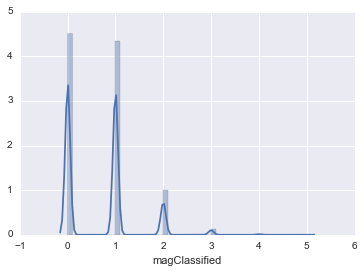

In [144]:
sns.distplot(quakes.magClassified)

In [2]:
quakes["country"] = quakes.place.apply(lambda x: str(x).split(", ")[-1])

In [73]:
okc = quakes[quakes["country"] =="Oklahoma"]
# okc = quakes[quakes["country"] =="Ok"]
len(okc)

5685

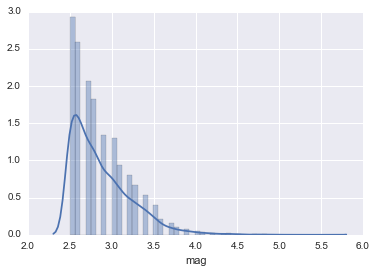

In [26]:
sns.distplot(okc.mag)

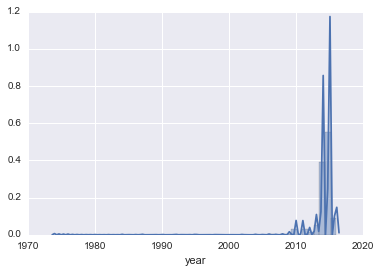

In [39]:
sns.distplot(okc.year)

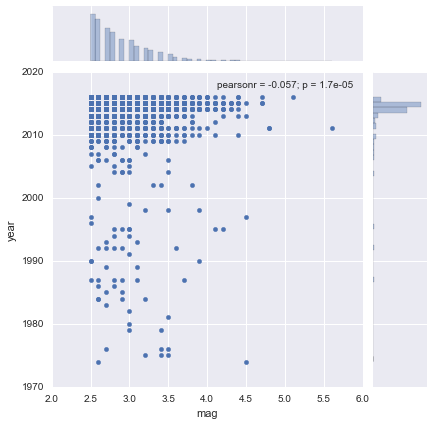

In [41]:
sns.jointplot(okc.mag, okc.year)

In [24]:
predictors = ["latitude", "longitude"]
test_models(models, okc[predictors], okc.magClassified)

RandomForest
0.98804080197
Logistic
0.988392543088


In [83]:
ca.magClassified.value_counts()

0    35799
1    17837
2     2101
3      207
4       34
5        6
Name: magClassified, dtype: int64

In [3]:
ca = quakes[(quakes["country"] =="California")| (quakes["country"] =="CA")]
# okc = quakes[quakes["country"] =="Ok"]
len(ca)
# (42.098222, -125.969238) top
# (32.063956, -113.840332) bot 

55984

In [80]:
predictors = ["latitude", "longitude", "year", "depth", "magTypeClassified"]
test_models(models, ca[predictors], ca.magClassified)

RandomForest
0.71931266076
Logistic
0.638075164333


In [82]:
predictors = ["latitude", "longitude", "year", "depth", "magTypeClassified"]
X_train, X_test, y_train, y_test = train_test_split(ca[predictors], ca.magClassified)
random.fit(X_train, y_train)
random.score(X_test, y_test)

0.72092026293226641

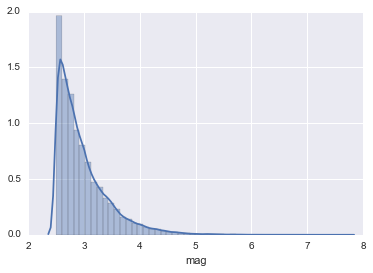

In [66]:
sns.distplot(ca.mag)

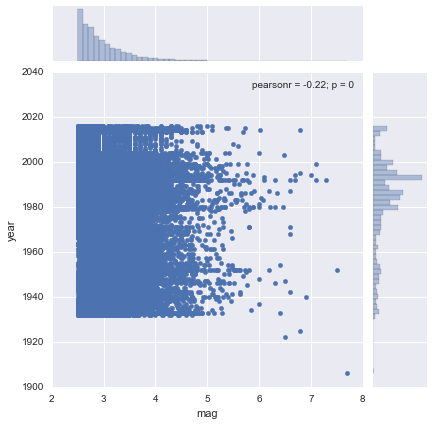

In [42]:
sns.jointplot(ca.mag, ca.year)

In [12]:
quakes["fault"] = quakes.place.apply(lambda x: True if "Ridge" in str(x).split() else False)
quakes.fault.value_counts()


False    674520
True      12448
Name: fault, dtype: int64

In [8]:
predictors = ["latitude", "longitude", "depth", "year", "month","hour"]
test_models(models, quakes[predictors], quakes.magClassified)

RandomForest
0.807443723725
Logistic
0.696527349163


In [ ]:
predictors = ["latitude", "longitude", "depthClassified", "year", "month","hour"]
test_models(models, quakes[predictors], quakes.magClassified)

In [189]:
count = 0
for i in alg.predict(X_test):
    if i >3:
        count+=1
print count

17


In [174]:
predictors = ["latitude", "longitude", "year", "month", "hour"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
logistic.fit(X_train, y_train)
logistic.score(X_test, y_test)

0.6869402941621735

In [183]:
quakes.groupby("magClassified").count()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,combined,country,magTypeClassified,year,month,hour,test,t,countryEncoding,Sex
magClassified,,,,,,,,,,,,,,,,,,,,,
0,309610,309610,309610,309610,309610,309489,201511,187192,42272,172925,...,309610,309610,309610,309610,309610,309610,309610,309610,309610,0
1,298257,298257,298257,298257,298257,298248,142460,152900,34884,253576,...,298257,298257,298257,298257,298257,298257,298257,298257,298257,0
2,68246,68246,68246,68246,68246,68244,22612,22735,3752,51789,...,68246,68246,68246,68246,68246,68246,68246,68246,68246,0
3,9522,9522,9522,9522,9522,9522,1969,1931,346,4736,...,9522,9522,9522,9522,9522,9522,9522,9522,9522,0
4,1241,1241,1241,1241,1241,1241,194,193,37,474,...,1241,1241,1241,1241,1241,1241,1241,1241,1241,0
5,92,92,92,92,92,92,19,19,2,31,...,92,92,92,92,92,92,92,92,92,0


In [220]:
for i in range(1):
    a=  logistic.predict_proba([42.2926850+i,-71.2644100-i, 2016, 3, 12])
    print weighted(a[0])
    
def weighted(a):
    s= 0
    for i in range(6):
        s += i *a[i]
    return s/6

0.0559032820271


/Users/bumho/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [4]:
# latLong = pd.DataFrame({
#         'latitude': np.array(quakes.latitude), 
#         'longitude': np.array(quakes.longitude)})
latLong = quakes[['latitude', 'longitude']]

Estimated number of clusters: 69


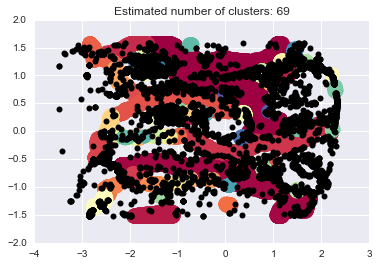

In [5]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(latLong)

# Compute DBSCAN
db = DBSCAN(eps=.03, min_samples=50).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

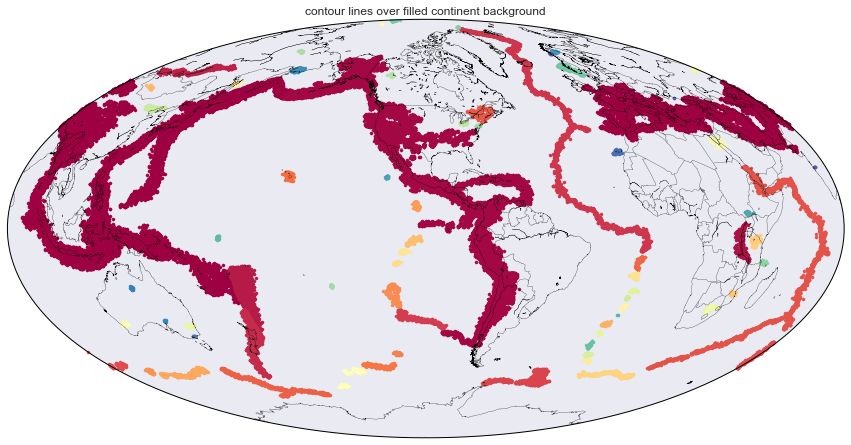

In [12]:
from mpl_toolkits.basemap import Basemap

# xx = []
# yy = []
# for i in range(len(labels)):
#     if labels[i] == 1:
#         xx.append(latLong.latitude[i])
#         yy.append(latLong.longitude[i])
# print len(xx)

plt.figure(figsize=(15,15))
map = Basemap(projection='hammer',lat_0=0,lon_0=-100,resolution='l')
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)

# x,y = map(yy, xx)
# map.scatter(x,y ,10,marker='o',color='b')

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
    class_member_mask = (labels == k)
    
    filtered = latLong[class_member_mask & core_samples_mask]

    x = filtered.latitude
    y = filtered.longitude
    
    x,y = map(np.array(y), np.array(x))
    map.scatter(x,y ,10,marker='o',color=col)

plt.title('contour lines over filled continent background')
plt.show()

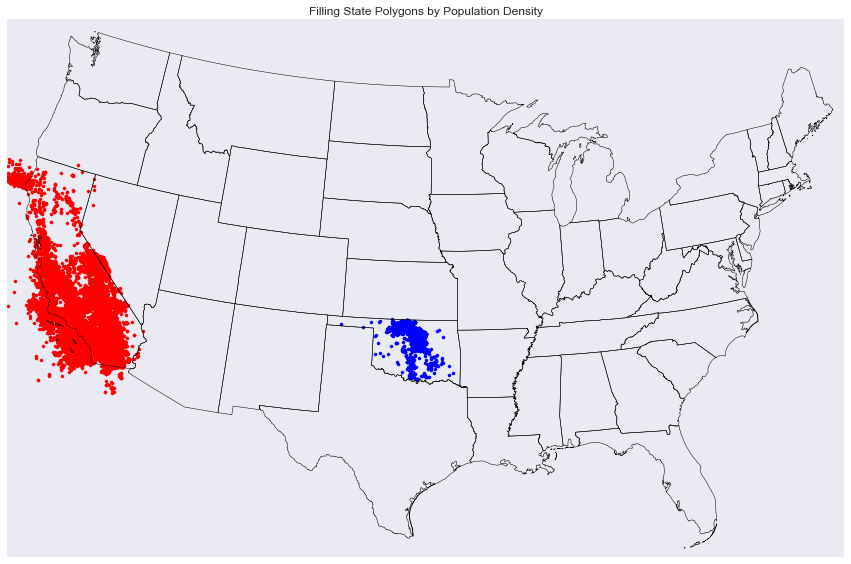

In [59]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon

plt.figure(figsize=(15,15))
# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# draw state boundaries.
# data from U.S Census Bureau
# http://www.census.gov/geo/www/cob/st2000.html
shp_info = m.readshapefile('st99_d00','states',drawbounds=True)
# population density by state from
# http://en.wikipedia.org/wiki/List_of_U.S._states_by_population_density
# draw meridians and parallels.
# m.drawparallels(np.arange(25,65,20),labels=[1,0,0,0])
# m.drawmeridians(np.arange(-120,-40,20),labels=[0,0,0,1])
# m.drawstates()
x,y = m(np.array(okc.longitude), np.array(okc.latitude))
m.scatter(x,y ,10,marker='o',color='b')

x,y = m(np.array(ca.longitude), np.array(ca.latitude))
m.scatter(x,y ,10,marker='o',color='r')

plt.title('Filling State Polygons by Population Density')
plt.show()

In [61]:
def depthClassify(depth):
    if depth <20:
        return 0
    elif depth <40:
        return 1
    elif depth <60:
        return 2
    elif depth <80:
        return 3 
    elif depth < 300:
        return 4
    elif depth <700:
        return 5
    else:
        return 6
    
quakes["depthClassified"] = quakes.depth.apply(depthClassify)

In [62]:
predictors = ["latitude", "longitude", "year", "month", "hour"]
test_models(models, quakes[predictors], quakes.depthClassified)

RandomForest
0.74296910482
Logistic
0.49171431566


0    310029
1    182958
4     90547
2     48865
3     29812
5     24742
6        15
Name: depthClassified, dtype: int64

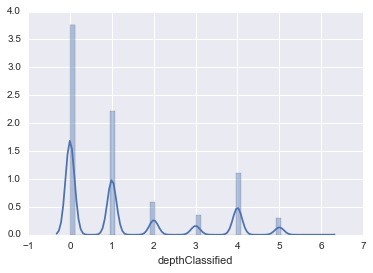

In [63]:
sns.distplot(quakes.depthClassified)
quakes.depthClassified.value_counts()

In [25]:
a = np.array(alg.predict_proba(X_test))

[[  4.31630865e-02   8.74487986e-01   8.22444342e-02   1.04493208e-04
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.40339518e-01   7.05882560e-01   4.78955685e-02
    5.88235294e-03   0.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  9.88000000e-01   1.20000000e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.05677656e-01   8.74725275e-01   1.95970696e-02   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  4.46801583e-02   8.79159866e-01   7.61599755e-02   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
(343484, 6)
[1 2 0 ..., 0 1 1]


In [23]:
# quakes["fault"] = quakes.place.apply(lambda x: True if "Ridge" in str(x).split() else False)
quakes["distance"] = quakes.place.apply(lambda x: [int(s) for s in re.findall(r'\d+', str(x))])
quakes["distance"]

0            []
1            []
2            []
3            []
4            []
5            []
6            []
7            []
8            []
9            []
10           []
11           []
12           []
13           []
14           []
15           []
16           []
17           []
18           []
19           []
20           []
21           []
22           []
23           []
24           []
25           []
26           []
27           []
28           []
29           []
          ...  
686938     [12]
686939     [53]
686940     [22]
686941     [39]
686942    [101]
686943     [55]
686944     [22]
686945     [35]
686946      [6]
686947      [6]
686948       []
686949     [54]
686950     [62]
686951      [6]
686952     [69]
686953       []
686954     [21]
686955    [153]
686956    [105]
686957     [30]
686958     [92]
686959     [67]
686960      [1]
686961    [147]
686962     [29]
686963    [127]
686964    [122]
686965    [102]
686966    [122]
686967     [85]
Name: distance, dtype: o

In [25]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

##### cluster data into K=1..10 clusters #####
#K, KM, centroids,D_k,cIdx,dist,avgWithinSS = kmeans.run_kmeans(X,10)

K = range(1,10)

  # scipy.cluster.vq.kmeans
KM = [kmeans(X_train,k) for k in K] # apply kmeans 1 to 10
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(X_train, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X_train.shape[0] for d in dist]  

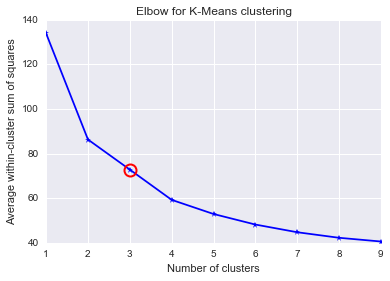

In [26]:
kIdx = 2
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')  

In [33]:
from sklearn.cluster import KMeans
km = KMeans(3, init='k-means++') # initialize
km.fit(X_train)
c = km.predict(X_train) # classify into three clusters

In [21]:
quakes["country"] = quakes.place.apply(lambda x: str(x).split(", ")[-1])
ca = quakes[(quakes["country"] =="California")| (quakes["country"] =="CA")]
# okc = quakes[quakes["country"] =="Ok"]
len(ca)

55984

In [10]:
from pylab import *
from sklearn.neighbors.kde import KernelDensity
from matplotlib import path
import random

def pnpoly(x, y, xyverts):
    """
    Included code for this matplotlib method directly in file b/c some versions don't have it. 
    inside = pnpoly(x, y, xyverts)
    Return 1 if x,y is inside the polygon, 0 otherwise.
    *xyverts*
        a sequence of x,y vertices.
    A point on the boundary may be treated as inside or outside.
    .. deprecated:: 1.2.0
        Use :meth:`~matplotlib.path.Path.contains_point` instead.
    """
    p = path.Path(xyverts)
    return p.contains_point([x, y])

def points_inside_poly(xypoints, xyverts):
    """
    Included code for this matplotlib method directly in file b/c some versions don't have it. 
    mask = points_inside_poly(xypoints, xyverts)
    Returns a boolean ndarray, True for points inside the polygon.
    *xypoints*
        a sequence of N x,y pairs.
    *xyverts*
        sequence of x,y vertices of the polygon.
    A point on the boundary may be treated as inside or outside.
    .. deprecated:: 1.2.0
        Use :meth:`~matplotlib.path.Path.contains_points` instead.
    """
    p = path.Path(xyverts)
    return p.contains_points(xypoints)


def points_in_polys(points, polys):
    """
    This method masks off the water (where data will be unreliable).
    """
    result = []
    for i, poly in enumerate(polys):
        if i == 0:
            mask = points_inside_poly(points, poly)
        else:
            mask = mask | points_inside_poly(points, poly)
    return np.array(mask)

def makeNearestNeighborsDensityPlot(data, min_lat = 31, max_lat = 43, min_lon = -125, max_lon = -112,
                                    cmap = 'bwr', color_min = None, color_max = None, res = .1):
    
    """
    Makes a map of the density of events. Red = higher density, blue = lower density. 
    filename: the name of the file that contains the data. See sample_data.csv for an example. Should contain at least two columns: lat (latitude) and lon (longitude). 
    col_of_interest: If None, uses kernel density estimation to just plot the overall density of events. If not None, col_of_interest should be a column that contains 0s and 1s, where 1 denotes events of interest and 0 denotes background events; then uses k-nearest neighbors to estimate the fraction of events which are 1s. 
    title_string: The title for the map. 
    min_lat, max_lat, min_long, max_long: the boundaries of the map, in degrees. Negative longitudes = west; negative latitudes = south. By default set to borders of North America. 
    maskOffWater: if True, does not map for water. True by default. 
    cmap: the name of the colormap to use. See http://matplotlib.org/examples/color/colormaps_reference.html for list of options. 
    color_min, color_max: which densities are mapped to the maximum and minimum colors. For k-nearest neighbors, set to 0 and 1 by default; for kernel density estimation, set to 0 and the maximum density estimate by default. May have to play with these to get informative maps. 
    n_neighbors: for k-nearest neighbors, the number of neighbors to use to compute densities. Try increasing if the map is very spiky. 
    res: how high-resolution the map is. Lower numbers = HIGHER resolution (but will take longer to make.)
    weights: for k-nearest neighbors, how to weight the points as a function of distance. By default uses a Gaussian kernel. Don't play with this unless you know what you're doing. 
    """
    geolocated = data 
    
    print "model fitting"
    model = KernelDensity(kernel='gaussian', bandwidth = 1).fit(geolocated[['latitude', 'longitude']])
    
    #Create a grid of points at which to predict. 
    x = np.arange(min_lat, max_lat, res)
    y = np.arange(min_lon, max_lon, res)
    X, Y = meshgrid(x, y)
    numel = len(X) * len(X[0, :])
    Z = np.zeros(X.shape)
    unraveled_x = X.reshape([numel, 1])
    unraveled_y = Y.reshape([numel, 1])
    data_to_eval = np.hstack([unraveled_x, unraveled_y])
    
    #Make predictions using appropriate model. 
    print "making predictions"
    density = np.exp(model.score_samples(data_to_eval))
    print density
    color_min = 0
    color_max = density.max()

    #Make map. 
    print "making map"
    figure(figsize = [15, 15])    
    m = Basemap(llcrnrlat = min_lat, urcrnrlat = max_lat, llcrnrlon = min_lon, urcrnrlon=max_lon, resolution='l', fix_aspect = False)

    m.drawcoastlines()
    x, y = m(data_to_eval[:,1], data_to_eval[:,0])
#     loc = np.c_[x, y]
#     polys = [p.boundary for p in m.landpolygons]
#     on_land = points_in_polys(loc, polys) 
#     density[~on_land] = (color_min + color_max) / 2
    
    print density
    
    density = density.reshape(X.shape)
    contourf(Y, X, density, levels = np.linspace(color_min, color_max, 50))
    m.drawcoastlines(linewidth = 2)
    m.drawcountries(linewidth = 2)
    m.drawstates(linewidth = 2)
    colorbar()
    set_cmap(cmap)

    show()

    print "done"
    return density

model fitting
making predictions
[  7.25326775e-09   9.71243269e-09   1.29131893e-08 ...,   1.49337199e-16
   8.85403497e-17   5.20910787e-17]
making map
[  7.25326775e-09   9.71243269e-09   1.29131893e-08 ...,   1.49337199e-16
   8.85403497e-17   5.20910787e-17]


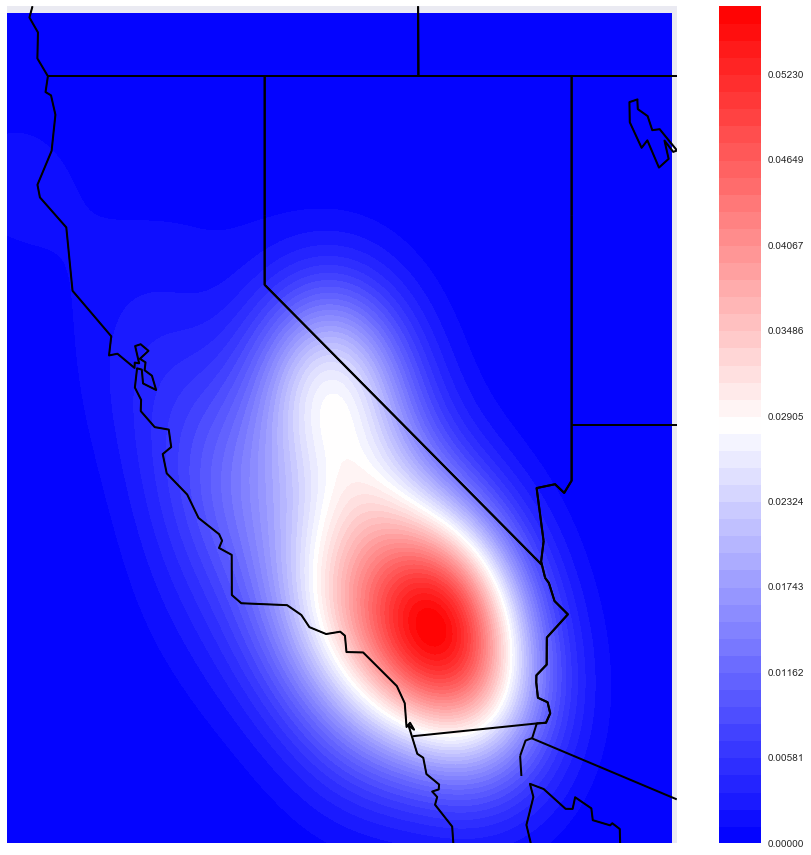

done


In [109]:
den = makeNearestNeighborsDensityPlot(ca)

In [13]:
print den[-122.431297][37.773972]
print den[-117.257767][32.842674]
print den[33.9387][-116.372171]
# 33.9387
print den.shape
# print den[129]
print den[80][29]

[ 31.   31.1  31.2  31.3  31.4  31.5  31.6  31.7  31.8  31.9  32.   32.1
  32.2  32.3  32.4  32.5  32.6  32.7  32.8  32.9  33.   33.1  33.2  33.3
  33.4  33.5  33.6  33.7  33.8  33.9  34.   34.1  34.2  34.3  34.4  34.5
  34.6  34.7  34.8  34.9  35.   35.1  35.2  35.3  35.4  35.5  35.6  35.7
  35.8  35.9  36.   36.1  36.2  36.3  36.4  36.5  36.6  36.7  36.8  36.9
  37.   37.1  37.2  37.3  37.4  37.5  37.6  37.7  37.8  37.9  38.   38.1
  38.2  38.3  38.4  38.5  38.6  38.7  38.8  38.9  39.   39.1  39.2  39.3
  39.4  39.5  39.6  39.7  39.8  39.9  40.   40.1  40.2  40.3  40.4  40.5
  40.6  40.7  40.8  40.9  41.   41.1  41.2  41.3  41.4  41.5  41.6  41.7
  41.8  41.9  42.   42.1  42.2  42.3  42.4  42.5  42.6  42.7  42.8  42.9]
[-125.  -124.9 -124.8 -124.7 -124.6 -124.5 -124.4 -124.3 -124.2 -124.1
 -124.  -123.9 -123.8 -123.7 -123.6 -123.5 -123.4 -123.3 -123.2 -123.1
 -123.  -122.9 -122.8 -122.7 -122.6 -122.5 -122.4 -122.3 -122.2 -122.1
 -122.  -121.9 -121.8 -121.7 -121.6 -121.5 -121.4 -121.3

In [76]:
x, y = m(-122.431297,37.773972 )
loc = np.c_[x, y]
# loc = np.c_[x, y]
polys = [p.boundary for p in m.landpolygons]
on_land = points_in_polys(loc, polys) 
density[~on_land] = (color_min + color_max) / 2
print density[~on_land]
print density[x][y]
x, y = m(-117.257767,32.842674 )
print x,y
# 32.842674 -117.257767
print density[-117.257767][32.842674]
print x

[]
0.0284721740528
-117.257767 32.842674
0.0284721740528


/Users/bumho/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 130 but corresponding boolean dimension is 1
/Users/bumho/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 130 but corresponding boolean dimension is 1
/Users/bumho/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/bumho/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [12]:
# model = KernelDensity(kernel='gaussian', bandwidth = 1).fit(ca[['latitude', 'longitude']])
min_lat = 31
max_lat = 43
min_lon = -125
max_lon = -112
res = .1
cmap = 'bwr'

x = np.arange(min_lat, max_lat, res)
y = np.arange(min_lon, max_lon, res)
print "xy"
X, Y = meshgrid(x, y)
numel = len(X) * len(X[0, :])
Z = np.zeros(X.shape)
print "unravel"
unraveled_x = X.reshape([numel, 1])
unraveled_y = Y.reshape([numel, 1])
data_to_eval = np.hstack([unraveled_x, unraveled_y])

xy
unravel


In [89]:
data_to_eval.shape


(15600, 2)

In [50]:
print "start"
density = np.exp(model.score_samples(data_to_eval))
if color_min is None:
    color_min = 0
if color_max is None:
    color_max = density.max()

start


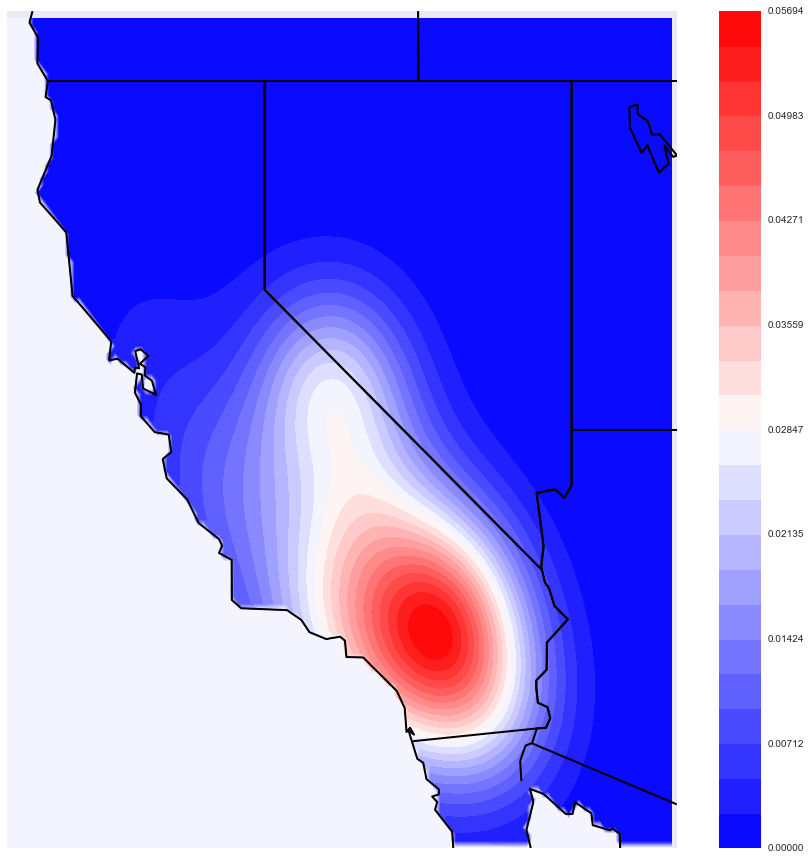

In [51]:
figure(figsize = [15, 15])    
m = Basemap(llcrnrlat = min_lat, urcrnrlat = max_lat, llcrnrlon = min_lon, urcrnrlon=max_lon, resolution='l', fix_aspect = False)
if maskOffWater:
    m.drawcoastlines()
    x, y = m(data_to_eval[:,1], data_to_eval[:,0])
    loc = np.c_[x, y]
    polys = [p.boundary for p in m.landpolygons]
    on_land = points_in_polys(loc, polys) 
    density[~on_land] = (color_min + color_max) / 2

density = density.reshape(X.shape)
contourf(Y, X, density, levels = np.linspace(color_min, color_max, 25))
m.drawcoastlines(linewidth = 2)
m.drawcountries(linewidth = 2)
m.drawstates(linewidth = 2)
colorbar()
set_cmap(cmap)

show()

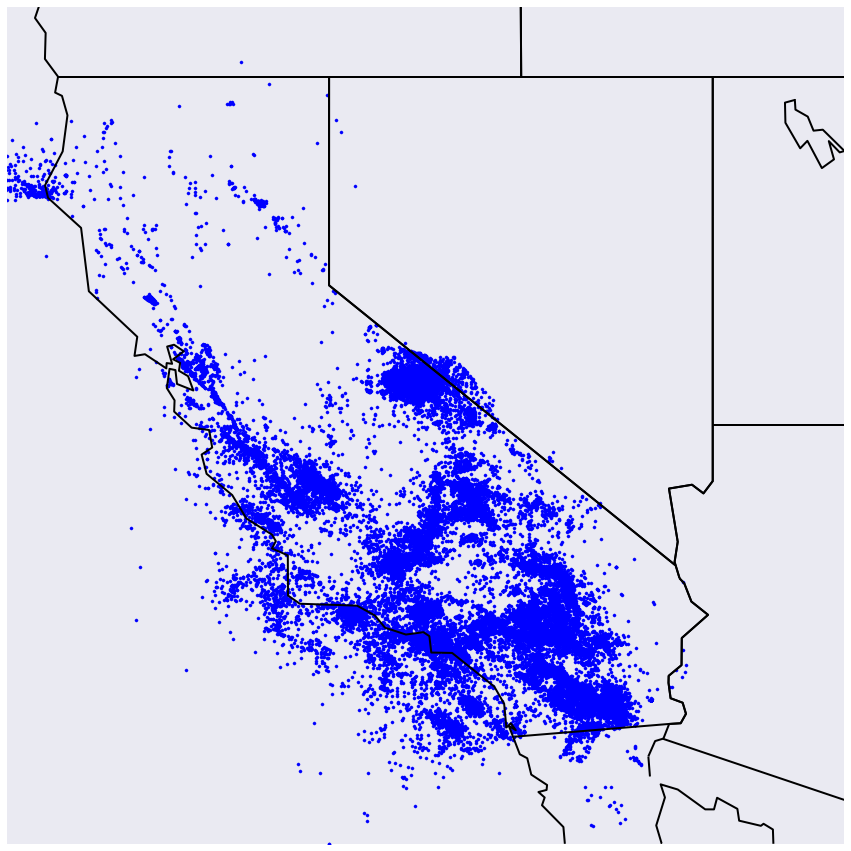

In [14]:
figure(figsize = [15, 15]) 
m = Basemap(llcrnrlat = min_lat, urcrnrlat = max_lat, llcrnrlon = min_lon, urcrnrlon=max_lon, resolution='l', fix_aspect = False)
m.drawcoastlines(linewidth = 2)
m.drawcountries(linewidth = 2)
m.drawstates(linewidth = 2)
# colorbar()
# set_cmap(cmap)
x,y = m(np.array(ca.longitude), np.array(ca.latitude))
m.scatter(x,y ,10,marker='o',color='b')

show()